# Should My Child Eat This?

### One of the biggest challenges I’ve experienced as a mother is getting my son to eat healthy food. He prefers processed food such as crackers or cookies. I'm always hesitant to given him what he wants in fear of the food being unhealthy. For that reason, I've decided to build a model that can determine if a food is healthy or not. 

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import math

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import math
from sklearn.linear_model import Lasso

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Prep/Cleaning

In [2]:
data = pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)

In [3]:
# We have 163 variables and 356,027 samples to begin with. Let the data cleaning begin!
data.shape

(356027, 163)

In [4]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

In [5]:
# We have 107 continuous variables and we can see that some have no entries, which means they are not useful. 
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,283867.000000,283867.000000,0.0,283867.000000,0.0,0.0,295367.000000,869.000000,2.794970e+05,...,3228.000000,404.000000,182.000000,1383.000000,0.0,278.000000,254856.000000,254856.000000,0.0,0.0
mean,NaN,1.876851,0.023430,NaN,0.059736,NaN,NaN,1125.453320,587.216617,5.606587e+04,...,33.392680,60.360124,15.362637,52.102675,NaN,335.790664,9.166137,8.980656,NaN,NaN
std,NaN,2.501022,0.153094,NaN,0.280660,NaN,NaN,936.825952,713.255708,2.963385e+07,...,32.906834,29.262350,3.692658,19.028361,NaN,423.244817,8.999870,9.151757,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,382.000000,49.400000,1.000000e-01,...,0.000000,45.000000,12.000000,33.000000,NaN,82.650000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1092.000000,300.000000,5.290000e+00,...,25.000000,58.000000,15.000000,52.000000,NaN,190.950000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1674.000000,900.000000,2.000000e+01,...,55.000000,93.000000,15.000000,70.000000,NaN,378.700000,16.000000,16.000000,NaN,NaN
max,NaN,30.000000,2.000000,NaN,6.000000,NaN,NaN,231199.000000,3830.000000,1.566667e+10,...,100.000000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [6]:
# Lets delete all the continuous variables with no values entered. 
for column in data.columns:
    if len(data[str(column)].value_counts()) < 2:
        data.drop([str(column)],axis=1,inplace=True)

In [7]:
# Now we have 86 continuous variables. 
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,283867.000000,283867.000000,283867.000000,295367.000000,869.000000,2.794970e+05,263823.000000,2.000000,4.000000,27.000000,...,91.000000,33.000000,52.000000,3228.000000,404.000000,182.000000,1383.000000,278.000000,254856.000000,254856.000000
mean,1.876851,0.023430,0.059736,1125.453320,587.216617,5.606587e+04,5.092460,6.040000,36.136182,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,9.166137,8.980656
std,2.501022,0.153094,0.280660,936.825952,713.255708,2.963385e+07,7.965148,0.226274,24.101433,3.939718,...,7.725321,69.605988,2.013490,32.906834,29.262350,3.692658,19.028361,423.244817,8.999870,9.151757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,5.880000,0.044730,0.064000,...,0.000000,0.000720,0.000000,0.000000,0.000000,8.000000,6.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,382.000000,49.400000,1.000000e-01,0.000000,5.960000,34.661183,7.100000,...,0.016500,0.035000,6.275000,0.000000,45.000000,12.000000,33.000000,82.650000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1092.000000,300.000000,5.290000e+00,1.790000,6.040000,47.600000,12.800000,...,0.021000,0.039000,7.200000,25.000000,58.000000,15.000000,52.000000,190.950000,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1674.000000,900.000000,2.000000e+01,7.140000,6.120000,49.075000,13.200000,...,0.042500,0.400000,7.500000,55.000000,93.000000,15.000000,70.000000,378.700000,16.000000,16.000000
max,30.000000,2.000000,6.000000,231199.000000,3830.000000,1.566667e+10,550.000000,6.200000,49.300000,15.400000,...,44.000000,400.000000,8.400000,100.000000,100.000000,25.000000,100.000000,2842.000000,40.000000,40.000000


In [8]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# We can see that there are other variables that won't be of use for us (e.g., url).
# Lets get rid of these along with some repeated variables.
data.drop(['url','creator','created_t', 'created_datetime', 'last_modified_datetime', 'generic_name',
           'image_small_url','image_url', 'main_category', 'states_tags', 'states', 'additives_tags', 
           'traces_tags', 'last_modified_t', 'packaging_tags', 'brands_tags', 'categories_tags', 
           'categories', 'origins_tags', 'manufacturing_places_tags', 'labels', 'labels_tags', 
           'emb_codes_tags', 'countries_tags','countries','traces'], 
          axis=1, inplace=True)

In [10]:
# Lets take a look at some categorical variables. 
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [11]:
describe_categorical(data)

,code,product_name,quantity,packaging,brands,categories_en,origins,manufacturing_places,labels_en,emb_codes,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries_en,ingredients_text,allergens,allergens_en,traces_en,serving_size,additives,additives_en,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_en,main_category_en
count,356001,338515,119285,89960,326977,103301,25050,42008,59204,32490,20872,26,22502,66565,57701,355752,283893,37176,20,28420,216621,283825,170189,6572,14328,254856,129006,132689,355975,103249
unique,356001,249245,15563,16466,66961,24112,5244,8076,16004,9210,1696,3,2733,5741,3646,779,238920,16575,20,3926,25928,228280,39941,14,180,5,14,42,1068,3639
top,7610800170044,Ice Cream,500 g,"Sachet,Plastique",Carrefour,"Beverages,Non-sugared beverages",France,France,"Organic,EU Organic,fr:AB Agriculture Biologique",EMB 56251E,"47.633333,-2.666667",a,theix-morbihan-france,France,Carrefour,United States,"Carbonated water, natural flavor.",blé,http://en.openfoodfacts.org/images/products/30...,Nuts,240 ml (8 fl oz),[ extra-virgin-olive-oil -> en:extra-virgin-o...,E330 - Citric acid,huile-de-palme,e471-mono-et-diglycerides-d-acides-gras-alimen...,d,unknown,unknown,"To be completed,Nutrition facts completed,Ingr...",Plant-based foods and beverages
freq,1,411,5285,2633,3670,2345,6159,11225,5080,229,297,11,286,14543,6878,173159,222,1495,1,2491,5496,397,8656,6239,3584,72436,43603,43603,167862,22950


In [12]:
data.drop(['code', 'product_name', 'quantity', 'packaging', 'brands', 'categories_en', 'origins', 
           'manufacturing_places', 'labels_en', 'emb_codes', 'first_packaging_code_geo', 'cities', 
           'cities_tags', 'purchase_places', 'stores', 'countries_en', 'ingredients_text', 
           'allergens', 'allergens_en', 'traces_en', 'serving_size', 'additives', 'additives_en', 
           'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 
           'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states_en', 'main_category_en'], 
          axis=1, inplace=True)

In [13]:
# We now have 86 variables total.
data.shape

(356027, 86)

## EDAs

### Considering that we have 163 variables, we will complete full EDAs on only a few variables.  To me, some of the most important nutrition facts are sugar, caffeine, and saturated fat. Calories are not really a factor as my son is more on the slim side. However, sugar and caffeine are never good for a child. Finally, saturated fat is not good for anyone (that I know of). 

### sugars_100g EDA

In [14]:
# sugars_100g is a continuous variable. 
data.sugars_100g.value_counts()

0.00     40003
3.57      7150
0.50      6345
3.33      3706
1.00      3565
2.00      2597
20.00     2491
10.00     2473
6.67      2272
50.00     2223
5.00      2209
3.00      2135
2.50      2069
7.14      2031
0.10      1896
0.70      1806
0.60      1776
4.00      1744
25.00     1703
0.80      1677
1.50      1581
40.00     1564
1.79      1427
33.33     1378
4.80      1281
30.00     1236
0.90      1231
11.00     1226
0.40      1208
12.00     1207
         ...  
51.93        1
71.41        1
48.98        1
25.87        1
7.71         1
33.71        1
31.94        1
25.77        1
52.36        1
30.41        1
46.91        1
19.07        1
11.28        1
70.60        1
66.30        1
19.13        1
32.98        1
30.32        1
46.82        1
24.83        1
34.39        1
10.72        1
82.46        1
21.93        1
79.40        1
14.28        1
11.52        1
11.06        1
79.80        1
24.48        1
Name: sugars_100g, Length: 4194, dtype: int64

In [15]:
# There are 76,841 missing values of sugars_100g.
data[data.sugars_100g.isnull()]

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,1552.0,NaN,1.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,1490.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,0.0,3586.0,NaN,100.00,7.14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,0.0,0.0,1393.0,NaN,1.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.0,0.0,0.0,1540.0,NaN,1.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.0,0.0,0.0,2590.0,NaN,42.86,4.76,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.0,0.0,0.0,2536.0,NaN,48.48,9.09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,0.0,0.0,0.0,1515.0,NaN,2.13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data.sugars_100g.min()

-17.859999999999999

In [17]:
data.sugars_100g.max()

3520.0

In [18]:
data.sugars_100g.mean()

15.673428227960812

In [19]:
data.sugars_100g.std()

21.98363546611446

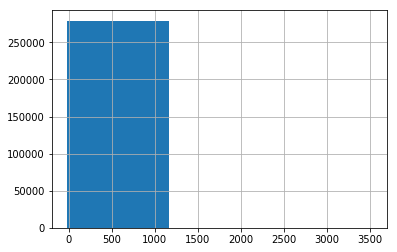

In [20]:
data.sugars_100g.hist(bins=3)

### saturated-fat_100g EDA

In [21]:
# saturated-fat_100g is a continuous variable. 
data['saturated-fat_100g'].value_counts()

0.0000      74037
0.1000       7658
0.5000       4172
3.5700       3490
0.2000       3482
1.0000       3240
0.3000       3148
7.1400       2881
0.4000       2811
5.0000       2362
3.3300       2214
2.0000       2207
1.7900       2194
10.0000      2133
20.0000      2110
14.2900      2052
6.6700       2021
0.6000       1973
0.8000       1886
2.5000       1844
0.7000       1828
17.8600      1779
15.0000      1716
5.3600       1701
21.4300      1655
1.5000       1556
12.5000      1553
0.9000       1530
3.0000       1505
10.7100      1485
            ...  
37.8000         1
34.3000         1
5.1800          1
15.6300         1
0.0220          1
18.9500         1
41.3000         1
10.4600         1
0.0223          1
9.4500          1
12.9200         1
23.9500         1
0.1620          1
35.7000         1
58.7000         1
0.2720          1
47.1000         1
32.9000         1
21.7900         1
0.9410          1
11.3800         1
4.5400          1
34.1000         1
28.2700         1
51.2000   

In [22]:
# There are 92,204 missing values of saturated-fat_100g.
data[data['saturated-fat_100g'].isnull()]

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,1552.0,NaN,1.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,1490.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,0.0,0.0,1393.0,NaN,1.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.0,0.0,0.0,1540.0,NaN,1.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,0.0,0.0,0.0,1582.0,NaN,2.22,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.0,0.0,0.0,1490.0,NaN,6.67,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,0.0,0.0,0.0,1569.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0.0,0.0,0.0,1393.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data['saturated-fat_100g'].min()

0.0

In [24]:
data['saturated-fat_100g'].max()

550.0

In [25]:
data['saturated-fat_100g'].mean()

5.092460343981409

In [26]:
data['saturated-fat_100g'].std()

7.965147846264368

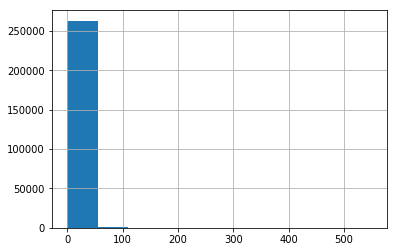

In [27]:
data['saturated-fat_100g'].hist()

### caffeine_100g EDA

In [28]:
# caffeine_100g is a continuous variable. 
data.caffeine_100g.value_counts()

0.02000     10
0.00000     10
0.03200      8
0.02100      5
0.01800      4
4.00000      3
0.80000      2
0.01200      2
0.03330      2
0.25000      2
0.00958      2
20.00000     2
0.01700      2
0.01850      1
0.01070      1
0.03400      1
42.28000     1
0.04400      1
44.00000     1
0.06300      1
1.25000      1
0.03477      1
0.03800      1
0.04100      1
0.03100      1
0.02500      1
0.02900      1
0.00783      1
0.09000      1
0.03300      1
0.04700      1
0.03000      1
0.05000      1
0.00450      1
1.00000      1
0.00400      1
8.42000      1
0.01000      1
2.80000      1
0.00970      1
0.01900      1
0.02800      1
0.08000      1
33.30000     1
0.04000      1
0.05200      1
0.00300      1
0.01500      1
0.01600      1
0.03600      1
Name: caffeine_100g, dtype: int64

In [29]:
# Almost all samples do not have an entry for caffeine_100g.
data[data.caffeine_100g.isnull()]

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,2243.0,NaN,28.57,28.57,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0
2,0.0,0.0,0.0,1941.0,NaN,17.86,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.0,0.0,0.0,2540.0,NaN,57.14,5.36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0
4,0.0,0.0,0.0,1552.0,NaN,1.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.0,0.0,1933.0,NaN,18.27,1.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,1490.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.0,0.0,1833.0,NaN,18.75,4.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0
8,0.0,0.0,0.0,2406.0,NaN,37.50,22.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,0.0,3586.0,NaN,100.00,7.14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data.caffeine_100g.min()

0.0

In [31]:
data.caffeine_100g.max()

44.0

In [32]:
data.caffeine_100g.mean()

2.0755028571428578

In [33]:
data.caffeine_100g.std()

7.7253208934889015

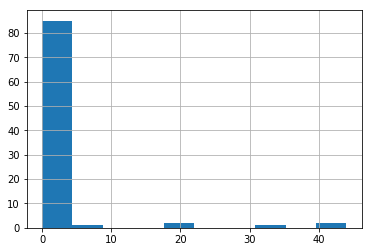

In [34]:
data.caffeine_100g.hist()

## Missing Values

In [35]:
# We need to take care of the missing values. 
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,283867.000000,283867.000000,283867.000000,295367.000000,869.000000,2.794970e+05,263823.000000,2.000000,4.000000,27.000000,...,91.000000,33.000000,52.000000,3228.000000,404.000000,182.000000,1383.000000,278.000000,254856.000000,254856.000000
mean,1.876851,0.023430,0.059736,1125.453320,587.216617,5.606587e+04,5.092460,6.040000,36.136182,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,9.166137,8.980656
std,2.501022,0.153094,0.280660,936.825952,713.255708,2.963385e+07,7.965148,0.226274,24.101433,3.939718,...,7.725321,69.605988,2.013490,32.906834,29.262350,3.692658,19.028361,423.244817,8.999870,9.151757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,5.880000,0.044730,0.064000,...,0.000000,0.000720,0.000000,0.000000,0.000000,8.000000,6.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,382.000000,49.400000,1.000000e-01,0.000000,5.960000,34.661183,7.100000,...,0.016500,0.035000,6.275000,0.000000,45.000000,12.000000,33.000000,82.650000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1092.000000,300.000000,5.290000e+00,1.790000,6.040000,47.600000,12.800000,...,0.021000,0.039000,7.200000,25.000000,58.000000,15.000000,52.000000,190.950000,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1674.000000,900.000000,2.000000e+01,7.140000,6.120000,49.075000,13.200000,...,0.042500,0.400000,7.500000,55.000000,93.000000,15.000000,70.000000,378.700000,16.000000,16.000000
max,30.000000,2.000000,6.000000,231199.000000,3830.000000,1.566667e+10,550.000000,6.200000,49.300000,15.400000,...,44.000000,400.000000,8.400000,100.000000,100.000000,25.000000,100.000000,2842.000000,40.000000,40.000000


In [36]:
# Impute all variables with mean. We might not want to do this with the caffeine variable. 
for v in data:
    data[str(v)].fillna(data[str(v)].mean(), inplace=True)

In [37]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,3.560270e+05,356027.000000,356027.000000,356027.000000,356027.000000,...,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000,356027.000000
mean,1.876851,0.023430,0.059736,1125.453320,587.216617,5.606587e+04,5.092460,6.040000,36.136183,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,9.166137,8.980656
std,2.233229,0.136702,0.250608,853.293243,35.217965,2.625639e+07,6.856595,0.000379,0.069962,0.033668,...,0.122828,0.659904,0.024099,3.132887,0.984512,0.083260,1.185535,11.805671,7.614510,7.743016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,5.880000,0.044730,0.064000,...,0.000000,0.000720,0.000000,0.000000,0.000000,8.000000,6.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,494.000000,587.216617,9.000000e-01,0.300000,6.040000,36.136182,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,3.000000,3.000000
50%,1.876851,0.000000,0.000000,1125.453320,587.216617,1.224000e+01,5.000000,6.040000,36.136182,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,9.166137,8.980656
75%,2.000000,0.000000,0.000000,1569.000000,587.216617,4.750000e+01,5.092460,6.040000,36.136182,10.383852,...,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,335.790664,14.000000,14.000000
max,30.000000,2.000000,6.000000,231199.000000,3830.000000,1.566667e+10,550.000000,6.200000,49.300000,15.400000,...,44.000000,400.000000,8.400000,100.000000,100.000000,25.000000,100.000000,2842.000000,40.000000,40.000000


In [38]:
# Lets make sure no missing values are left. 
for column in data.columns:
    if data[column].isnull().any():
            print (column)

In [39]:
y1=data.pop('nutrition-score-fr_100g')
y2=data.pop('nutrition-score-uk_100g')

In [40]:
# want to compute the average of our ys
# y = []

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, y2, test_size=.2, random_state=42)

In [42]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
list(zip (y_test, model.predict(X_test)))

[(8.980655742850864, 8.9737441030328498),
 (20.0, 20.0),
 (18.0, 17.23),
 (8.980655742850864, 8.9737441030328498),
 (12.0, 11.879613114857017),
 (8.980655742850864, 8.9806557428510878),
 (15.0, 15.0),
 (20.0, 19.969999999999999),
 (8.980655742850864, 8.9806557428507237),
 (8.980655742850864, 8.9806557428507876),
 (11.0, 11.01),
 (18.0, 18.23),
 (-3.0, -2.8999999999999999),
 (23.0, 23.0),
 (8.980655742850864, 8.9737441030328498),
 (5.0, 14.58),
 (9.0, 9.0),
 (-1.0, -1.0),
 (0.0, 0.0),
 (16.0, 15.6),
 (18.0, 18.0),
 (19.0, 18.940000000000001),
 (2.0, 2.0),
 (-2.0, -2.04),
 (8.980655742850864, 8.9806557428510878),
 (23.0, 23.0),
 (21.0, 20.890000000000001),
 (0.0, 0.0),
 (9.0, 8.9399999999999995),
 (10.0, 10.449999999999999),
 (12.0, 12.0),
 (-3.0, -2.2799999999999998),
 (-6.0, -6.5499999999999998),
 (8.980655742850864, 8.9806557428506952),
 (14.0, 14.0),
 (9.0, 9.0600000000000005),
 (0.0, 0.37),
 (-6.0, -6.0),
 (6.0, 5.8200000000000003),
 (25.0, 24.47980655742851),
 (1.0, 1.0),
 (8.98065

In [44]:
y_hat = model.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(mse)

0.804936223866


In [45]:
rmse = math.sqrt(mse)
print(rmse)

0.8971823804925603


In [46]:
r2 = r2_score(y_test, y_hat)
print(r2)

0.986608508123
